In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('IBM CLV.csv')
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


Problem Statement: Can we predict Customer Lifetime Value based on the profile of the customer?

Let's perform some cleanup of the data first.

In [3]:
df.isna().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [5]:
df.shape == df.drop_duplicates().shape

True

In [15]:
df.dtypes

Customer                          object
State                             object
Customer Lifetime Value          float64
Response                          object
Coverage                          object
Education                         object
Effective To Date                 object
EmploymentStatus                  object
Gender                            object
Income                             int64
Location Code                     object
Marital Status                    object
Monthly Premium Auto               int64
Months Since Last Claim            int64
Months Since Policy Inception      int64
Number of Open Complaints          int64
Number of Policies                 int64
Policy Type                       object
Policy                            object
Renew Offer Type                  object
Sales Channel                     object
Total Claim Amount               float64
Vehicle Class                     object
Vehicle Size                      object
dtype: object

In [16]:
for column in df.columns:
    print(df[column].value_counts())

AP89323    1
OY47486    1
ID40186    1
TR85083    1
EZ48947    1
          ..
JV12632    1
WW67905    1
UL64533    1
KR89806    1
OO49507    1
Name: Customer, Length: 9134, dtype: int64
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64
2248.449633     6
10972.067780    6
5619.689084     6
11981.984810    6
2530.705137     6
               ..
12349.702320    1
4046.936065     1
2121.313061     1
7232.609391     1
3297.904615     1
Name: Customer Lifetime Value, Length: 8041, dtype: int64
No     7826
Yes    1308
Name: Response, dtype: int64
Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64
Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: Education, dtype: int64
1/10/11    195
1/27/11    194
2/14/11    186
1/26/11    181
1/17/11    180
1/19/11    179
1/3/11     178
1/31/11    178
1/20/11  

As we're goint to use a linear regression model on some categorical variables, let's simplify some of the categories to make it easier for the model to analyse.

In [17]:
values_to_replace = df.Education.replace(to_replace=['College','Master','Doctor','Bachelor'], value='Bachelor or Above')
df.Education = values_to_replace
df.Education.value_counts()

Bachelor or Above       6512
High School or Below    2622
Name: Education, dtype: int64

State, Gender, Vehicle Class, Education, Vehicle Size, Marital status, Income 

Surprisingly, `income` doesn't correlated highly with customer lifetime value. In addition, we should drop some variables that can only be obtained after the customer has brought from us since we are looking to profile our ideal customer.

<AxesSubplot:>

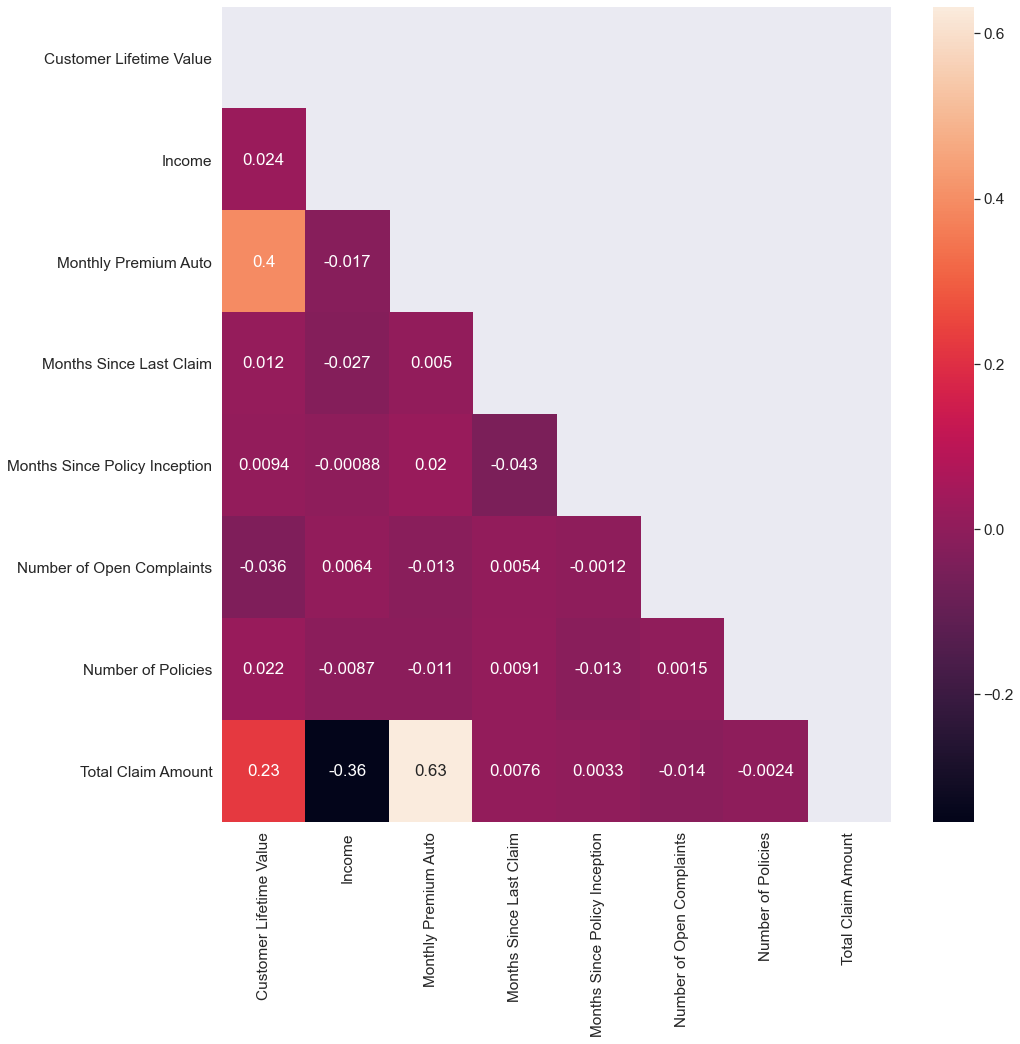

In [18]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True,mask=mask)


As expected, `Income` doesn't correlated with `Customer Lifetime Value` and there doesn't seem to be any clear seperation between `Gender`.

Text(0.5, 1.0, 'Plot of CLV against Income by Gender')

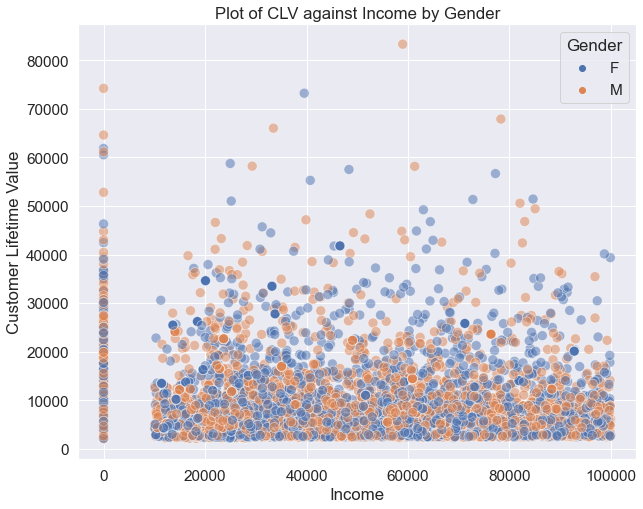

In [19]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='Income', y='Customer Lifetime Value', hue='Gender',data=df,s=100,alpha=0.5)
plt.title('Plot of CLV against Income by Gender')

Text(0.5, 1.0, 'Bar Chart of CLV against Education')

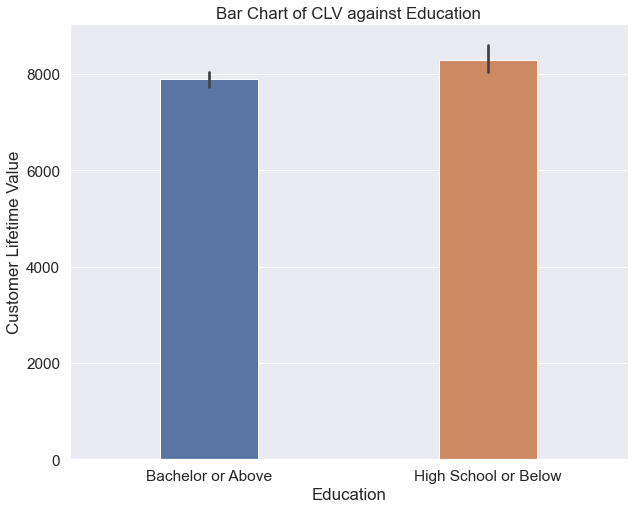

In [20]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='Education',y='Customer Lifetime Value',data=df)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .35)
plt.title('Bar Chart of CLV against Education')

Text(0.5, 1.0, 'Bar Chart of CLV against State')

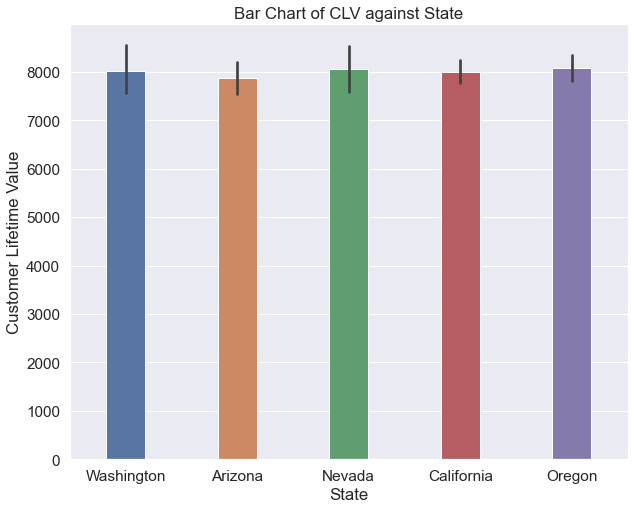

In [21]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='State',y='Customer Lifetime Value',data=df)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax, .35)
plt.title('Bar Chart of CLV against State')

Text(0.5, 1.0, 'Bar Chart of CLV against Marital Status')

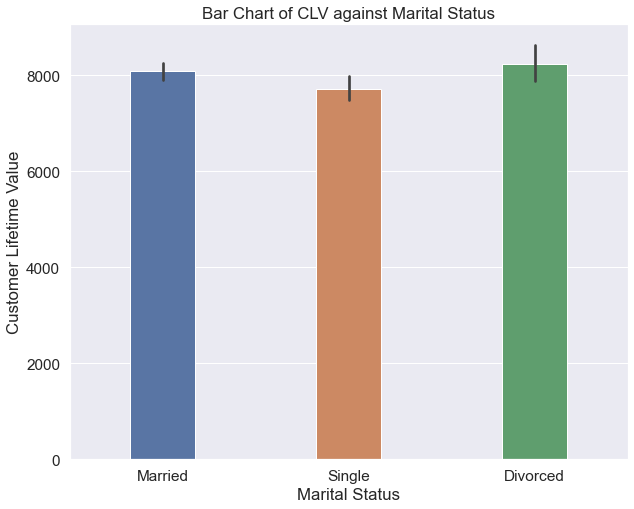

In [22]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='Marital Status',y='Customer Lifetime Value',data=df)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax, .35)
plt.title('Bar Chart of CLV against Marital Status')

Text(0.5, 1.0, 'Bar Chart of Vehicle Class against CLV')

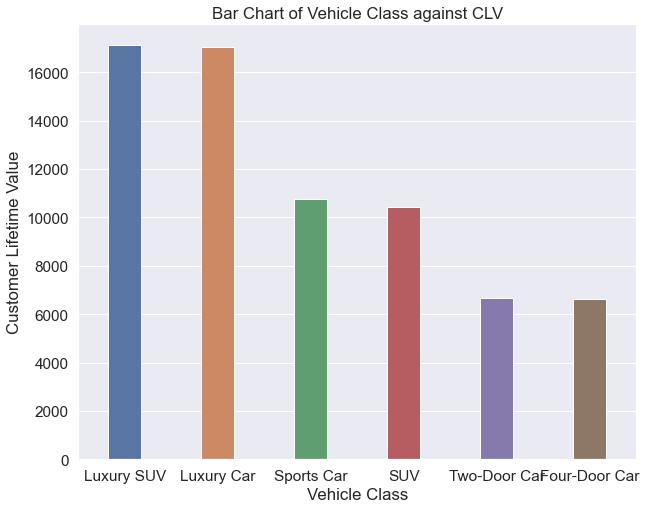

In [23]:
groupby = df.groupby('Vehicle Class')['Customer Lifetime Value'].mean()
groupby = groupby.sort_values(ascending = False)
groupby = pd.DataFrame(groupby)
plt.figure(figsize=(10,8))
ax = sns.barplot(x=groupby.index,y='Customer Lifetime Value',data=groupby)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax, .35)
plt.title('Bar Chart of Vehicle Class against CLV')

Text(0.5, 1.0, 'Bar Chart of CLV against Vehicle Size')

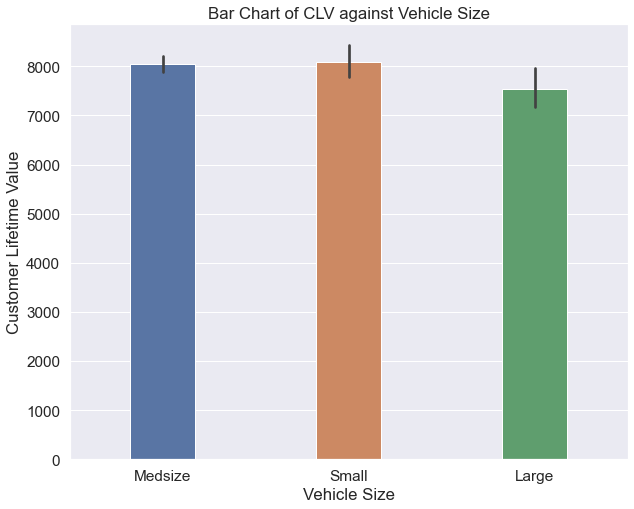

In [24]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='Vehicle Size',y='Customer Lifetime Value',data=df)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(ax, .35)
plt.title('Bar Chart of CLV against Vehicle Size')

It looks like ownwers with luxury cars are more valuable to the business, let's confirm this with some statistics.

In [25]:
df_luxury = df[(df['Vehicle Class'] == 'Luxury SUV') | (df['Vehicle Class'] == 'Luxury Car')]
df_luxury

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
31,UL64533,Nevada,18975.456110,No,Extended,High School or Below,1/22/11,Employed,M,65999,...,14,0,6,Corporate Auto,Corporate L2,Offer2,Agent,615.927769,Luxury SUV,Medsize
79,OM82309,California,58166.553510,No,Basic,Bachelor or Above,2/27/11,Employed,M,61321,...,30,1,2,Personal Auto,Personal L3,Offer2,Branch,427.631210,Luxury Car,Small
123,SH36774,California,15023.598580,No,Basic,High School or Below,1/12/11,Employed,M,28262,...,77,0,3,Personal Auto,Personal L3,Offer3,Web,921.600000,Luxury SUV,Medsize
181,KC11055,Nevada,16936.271470,No,Extended,Bachelor or Above,1/24/11,Employed,F,39411,...,29,2,4,Personal Auto,Personal L3,Offer3,Branch,1122.658899,Luxury Car,Medsize
196,AZ62651,Oregon,9951.707743,No,Premium,High School or Below,2/17/11,Employed,M,56855,...,1,0,1,Corporate Auto,Corporate L3,Offer4,Web,1836.000000,Luxury SUV,Medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923,VF65251,California,6674.177684,No,Basic,Bachelor or Above,1/3/11,Unemployed,M,0,...,14,0,1,Personal Auto,Personal L2,Offer4,Branch,1737.320276,Luxury SUV,Large
8943,FM12425,California,19337.901030,No,Extended,Bachelor or Above,2/8/11,Employed,M,26488,...,39,0,7,Personal Auto,Personal L2,Offer1,Web,1321.584957,Luxury SUV,Medsize
9026,UI19516,California,16909.927670,No,Extended,Bachelor or Above,2/22/11,Employed,M,65620,...,0,0,4,Corporate Auto,Corporate L2,Offer3,Agent,766.322388,Luxury Car,Medsize
9049,UZ14076,California,32104.699570,No,Premium,High School or Below,2/16/11,Employed,F,89546,...,18,1,2,Corporate Auto,Corporate L3,Offer3,Agent,2452.894264,Luxury SUV,Large


In [26]:
df_luxury.groupby('State')['Customer Lifetime Value'].describe()

,count,mean,std,min,25%,50%,75%,max
State,,,,,,,,
Arizona,59.0,16576.953020,11437.753044,7054.776317,8504.225593,14514.005190,18247.629405,60556.19213
California,118.0,16881.871429,11821.276079,6141.961623,8090.814053,14960.975025,19539.245250,73225.95652
Nevada,35.0,16200.250839,12544.750424,6601.611299,7198.871377,9366.816281,19068.223025,52811.49112
Oregon,106.0,17213.006416,13202.917566,5886.221122,8427.172486,13303.017240,21361.865267,83325.38119
Washington,29.0,19608.245285,15862.036693,7414.436023,11196.460020,15096.270230,19160.989940,74228.51604


In [27]:
df_luxury.groupby('Gender')['Customer Lifetime Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,158.0,16955.725518,11766.353826,6383.611136,8464.369794,14549.691275,19160.98994,73225.95652
M,189.0,17202.767184,13274.674761,5886.221122,7840.165778,14429.892840,19606.35999,83325.38119


In [28]:
df_luxury.groupby('Education')['Customer Lifetime Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Education,,,,,,,,
Bachelor or Above,235.0,17082.727044,12083.861864,5886.221122,7914.600823,14514.005190,19287.800395,73225.95652
High School or Below,112.0,17106.131913,13656.527548,6425.709981,8433.718372,14321.195315,19038.707987,83325.38119


In [29]:
df_luxury.groupby('Marital Status')['Customer Lifetime Value'].describe()

,count,mean,std,min,25%,50%,75%,max
Marital Status,,,,,,,,
Divorced,50.0,15695.988068,8349.076207,7082.830426,8427.172486,13429.05230,19160.98994,45708.65342
Married,183.0,18344.785059,13519.763814,6191.402312,7873.398009,15306.13396,21843.82199,83325.38119
Single,114.0,15688.004915,12472.457964,5886.221122,7840.165778,13039.04859,17415.09310,74228.51604


Let's prepare the data for the linear regression model.

In [30]:
X = df.drop(['Customer Lifetime Value', #Target variable
             'Monthly Premium Auto', #We should not know what the customer bought.
             'Total Claim Amount', #We should not know what happened after aquiring the customer.
             'Customer', #Unique ID
             'Number of Policies', #We should not know what the customer bought.
             'Effective To Date', #what the customer bought.
             'EmploymentStatus', #Information found in 'Income' column
             'Location Code',
             'Policy Type',
             'Policy',
             'Renew Offer Type',
             'Response',
             'Coverage',
             'Months Since Last Claim',
             'Months Since Policy Inception',
             'Number of Open Complaints',
             'Sales Channel'],axis=1)
y = df['Customer Lifetime Value']

In [31]:
income = preprocessing.normalize([X['Income']])
X['Income'] = income[0]
X

,State,Education,Gender,Income,Marital Status,Vehicle Class,Vehicle Size
0,Washington,Bachelor or Above,F,0.012170,Married,Two-Door Car,Medsize
1,Arizona,Bachelor or Above,F,0.000000,Single,Four-Door Car,Medsize
2,Nevada,Bachelor or Above,F,0.010546,Married,Two-Door Car,Medsize
3,California,Bachelor or Above,M,0.000000,Married,SUV,Medsize
4,Washington,Bachelor or Above,M,0.009480,Single,Four-Door Car,Medsize
...,...,...,...,...,...,...,...
9129,California,Bachelor or Above,M,0.015558,Married,Four-Door Car,Medsize
9130,California,Bachelor or Above,F,0.004672,Divorced,Four-Door Car,Medsize
9131,California,Bachelor or Above,M,0.000000,Single,Four-Door Car,Medsize
9132,California,Bachelor or Above,M,0.004745,Married,Four-Door Car,Large


In [32]:
column_dict = dict(X.dtypes)
encode_list = []
for key in column_dict:
     if column_dict[key] == np.dtype('O'):
            encode_list.append(key)
encode_list

['State',
 'Education',
 'Gender',
 'Marital Status',
 'Vehicle Class',
 'Vehicle Size']

In [33]:
for column in encode_list:
    print(column)
    print(df[column].value_counts())

State
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64
Education
Bachelor or Above       6512
High School or Below    2622
Name: Education, dtype: int64
Gender
F    4658
M    4476
Name: Gender, dtype: int64
Marital Status
Married     5298
Single      2467
Divorced    1369
Name: Marital Status, dtype: int64
Vehicle Class
Four-Door Car    4621
Two-Door Car     1886
SUV              1796
Sports Car        484
Luxury SUV        184
Luxury Car        163
Name: Vehicle Class, dtype: int64
Vehicle Size
Medsize    6424
Small      1764
Large       946
Name: Vehicle Size, dtype: int64


In [34]:
df.columns

Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [35]:
ordinal_list = ['Education','Vehicle Size']
encode_list
for column in ordinal_list:
    encode_list.remove(column)

In [36]:
for column in ordinal_list:
    print(column not in encode_list)

True
True


In [37]:
ohe = OneHotEncoder()
ohe.fit_transform(df[encode_list])
ohe.categories_

[array(['Arizona', 'California', 'Nevada', 'Oregon', 'Washington'],
       dtype=object),
 array(['F', 'M'], dtype=object),
 array(['Divorced', 'Married', 'Single'], dtype=object),
 array(['Four-Door Car', 'Luxury Car', 'Luxury SUV', 'SUV', 'Sports Car',
        'Two-Door Car'], dtype=object)]

In [38]:
oe_dict = {}
i = 0
for column in ordinal_list:
    loop_list = []
    for key in dict(X[column].value_counts()):
        loop_list.append(key)
    oe_dict[i] = loop_list
    i = i + 1
oe_dict

{0: ['Bachelor or Above', 'High School or Below'],
 1: ['Medsize', 'Small', 'Large']}

In [39]:
oe_dict[0] = ['High School or Below','Bachelor or Above']
oe_dict[1] = ['Small', 'Medsize','Large']

In [40]:
ordinal_list

['Education', 'Vehicle Size']

In [41]:
oe = OrdinalEncoder(categories=[oe_dict[0],oe_dict[1]])
oe.fit_transform(X[ordinal_list])
oe.categories_

[array(['High School or Below', 'Bachelor or Above'], dtype=object),
 array(['Small', 'Medsize', 'Large'], dtype=object)]

In [42]:
column_trans = make_column_transformer((OneHotEncoder(),encode_list),
                                      (OrdinalEncoder(categories=[oe_dict[0],
                                                                  oe_dict[1]]),
                                      ordinal_list),remainder='passthrough')
column_trans.fit_transform(X)

array([[0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.01216983],
       [1.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 1.        , 1.        ,
        0.01054636],
       ...,
       [0.        , 1.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 1.        , 2.        ,
        0.00474497],
       [0.        , 1.        , 0.        , ..., 1.        , 1.        ,
        0.        ]])

In [43]:
regr = LinearRegression()
pipe = make_pipeline(column_trans,regr)
pipe.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['State', 'Gender',
                                                   'Marital Status',
                                                   'Vehicle Class']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['High '
                                                                              'School '
                                                                              'or '
                                                                              'Below',
                                                                              'Bachelor '
                                                        

Scoring parameter can be taken from here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [44]:
cross_val_score(pipe,X,y,cv=5,scoring='neg_root_mean_squared_error').mean()

-6423.222767219459

Let's see if we can do any more optimization with lasso regression by changing the alpha values.

In [45]:
las = Lasso(max_iter=10000)
lasso_alphas = np.logspace(-6, 6, 20)
coefs_las = []
rmse_las = []
prediction = []
i=0
for a in lasso_alphas:
    las.set_params(alpha = a)
    pipe_las = make_pipeline(column_trans,las)
    pipe_las.fit(X,y)
    result = cross_val_score(pipe_las,X,y,cv=5,scoring='neg_root_mean_squared_error').mean()
    rmse_las.append(result)
    coefs_las.append(a)
    prediction.append(pipe_las.predict(X))
    print(i)
    i+=1
    
rmse_coef_las = zip(rmse_las,coefs_las)

C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68084191655.71805, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55323462886.33748, tolerance: 35326664.40313652
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55749262658.191086, tolerance: 35397107.82018515
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

0


C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68084194151.51935, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55323460704.44209, tolerance: 35326664.40313652
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55749268818.48915, tolerance: 35397107.82018515
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

1


C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68084198392.48334, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55323463717.740036, tolerance: 35326664.40313652
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55749272119.66977, tolerance: 35397107.82018515
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

2


C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68084215932.91974, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55323476103.747696, tolerance: 35326664.40313652
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55749286471.01506, tolerance: 35397107.82018515
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

3


C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68084289532.60654, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55323529116.46678, tolerance: 35326664.40313652
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55749348140.34044, tolerance: 35397107.82018515
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

4


C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68084601934.58148, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55323753989.0244, tolerance: 35326664.40313652
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55749610299.313446, tolerance: 35397107.82018515
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

5


C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68085895487.4371, tolerance: 43117071.892719924
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55324683639.10219, tolerance: 35326664.40313652
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55750699171.788956, tolerance: 35397107.82018515
  model = cd_fast.enet_coordinate_descent(
C:\Users\ryan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [46]:
for element in rmse_coef_las:
    print(element)
least_error = max(rmse_las)
least_error_index = rmse_las.index(least_error)
optimal_alpha = coefs_las[least_error_index]
optimal_alpha

(-6422.873194749827, 1e-06)
(-6422.87319457297, 4.281332398719396e-06)
(-6422.873193834812, 1.8329807108324375e-05)
(-6422.873190683393, 7.847599703514606e-05)
(-6422.873177355565, 0.0003359818286283781)
(-6422.873103779673, 0.0014384498882876629)
(-6422.872922620917, 0.00615848211066026)
(-6422.8681821634, 0.026366508987303555)
(-6422.871338429946, 0.11288378916846883)
(-6423.225147623961, 0.4832930238571752)
(-6424.242293212817, 2.06913808111479)
(-6422.665542005767, 8.858667904100814)
(-6431.927539880392, 37.92690190732246)
(-6560.134786515626, 162.37767391887175)
(-6853.806387800764, 695.1927961775591)
(-6857.648520191158, 2976.3514416313133)
(-6857.648520191158, 12742.749857031322)
(-6857.648520191158, 54555.947811685146)
(-6857.648520191158, 233572.14690901214)
(-6857.648520191158, 1000000.0)


8.858667904100814

In [47]:
las = Lasso(max_iter=100000,alpha=optimal_alpha)
pipe_las = make_pipeline(column_trans,las)
pipe_las.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['State', 'Gender',
                                                   'Marital Status',
                                                   'Vehicle Class']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['High '
                                                                              'School '
                                                                              'or '
                                                                              'Below',
                                                                              'Bachelor '
                                                        

These are the weights of the model features.

In [48]:
pipe_las.named_steps['lasso'].coef_

array([  -39.46499266,    -0.        ,     0.        ,     0.        ,
          24.00302473,   219.95147786,    -0.        ,   207.7607673 ,
          -0.        ,  -384.10706622, -3837.96608697,  6108.1757973 ,
        6200.05495431,    -0.        ,   105.15268559, -3760.37436012,
        -281.07021478,  -176.79845074,     0.        ])

In [49]:
cross_val_score(pipe_las,X,y,cv=5,scoring='r2').mean()

0.12164667667099885

In [50]:
cross_val_score(pipe_las,X,y,cv=5,scoring='neg_root_mean_squared_error').mean()

-6422.665542005767

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
pipe_las.fit(X_train,y_train)
pipe_las.predict(X_test)

array([10556.16077998,  6808.67368726,  6934.4422775 , ...,
       10249.26526514,  6786.3068019 , 10223.23448671])

In [53]:
y_pred = pipe_las.predict(X_test)
y_actual = y_test

In [54]:
rmse = (sum((y_pred - y_actual)**2) / len(y_actual))**0.5
rmse

6700.231613657332

In [55]:
coef_values = pipe_las.named_steps['lasso'].coef_
coef_values

array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.55290956e+01,
        0.00000000e+00,  1.15962024e+02, -7.96923886e-14,  2.73166167e+02,
       -0.00000000e+00, -2.79862112e+02, -3.67322679e+03,  6.42953069e+03,
        6.02807785e+03, -0.00000000e+00,  0.00000000e+00, -3.49805791e+03,
       -3.37328443e+02, -1.83234921e+02,  0.00000000e+00])

In [56]:
coefs_list = []
states = ['Arizona', 'California', 'Nevada', 'Oregon', 'Washington']
gender = ['F', 'M']
marital = ['Divorced', 'Married', 'Single']
vehicle_class = ['Four-Door Car', 'Luxury Car', 'Luxury SUV', 'SUV', 'Sports Car','Two-Door Car']

lists = [states,gender,marital,vehicle_class]
for element in lists:
    coefs_list.extend(element)
coefs_list.extend(ordinal_list)
coefs_list.append('Income')
coefs_list

['Arizona',
 'California',
 'Nevada',
 'Oregon',
 'Washington',
 'F',
 'M',
 'Divorced',
 'Married',
 'Single',
 'Four-Door Car',
 'Luxury Car',
 'Luxury SUV',
 'SUV',
 'Sports Car',
 'Two-Door Car',
 'Education',
 'Vehicle Size',
 'Income']

Let's make the weights of the model features more readable by putting it into a dictionary.

In [86]:
coefs_dict = {}
for i in range(len(coefs_list)):
    if coef_values[i] != 0:
        coefs_dict[coefs_list[i]] = [coef_values[i]]
coefs_dict

{'Oregon': [-85.52909557292108],
 'F': [115.96202396228429],
 'M': [-7.969238860442866e-14],
 'Divorced': [273.1661665247139],
 'Single': [-279.86211248367016],
 'Four-Door Car': [-3673.2267865889157],
 'Luxury Car': [6429.530687251344],
 'Luxury SUV': [6028.077846024636],
 'Two-Door Car': [-3498.057908631853],
 'Education': [-337.3284432316368],
 'Vehicle Size': [-183.2349209949239]}

In [91]:
df_coefs = pd.DataFrame(coefs_dict).T
df_coefs[0]

Oregon          -8.552910e+01
F                1.159620e+02
M               -7.969239e-14
Divorced         2.731662e+02
Single          -2.798621e+02
Four-Door Car   -3.673227e+03
Luxury Car       6.429531e+03
Luxury SUV       6.028078e+03
Two-Door Car    -3.498058e+03
Education       -3.373284e+02
Vehicle Size    -1.832349e+02
Name: 0, dtype: float64

In [92]:
df_coefs = df_coefs.round(2)
df_coefs['Non Zero Coefficient Weights'] = df_coefs[0]
df_coefs = df_coefs.drop(0,axis=1)

In [93]:
df_coefs

,Non Zero Coefficient Weights
Oregon,-85.53
F,115.96
M,-0.00
Divorced,273.17
Single,-279.86
Four-Door Car,-3673.23
Luxury Car,6429.53
Luxury SUV,6028.08
Two-Door Car,-3498.06
Education,-337.33


In [95]:
test_df = pd.read_csv('test.csv')
pipe_las.predict(test_df)

array([17558.05457871])

In [98]:
df['Customer Lifetime Value'].median()

5780.182197

Conclusion:

Although there is room for improvement by using a different mode, the most important characteristics of our ideal customer are (In order): 

1. Having a luxury car
2. Divorced
3. Female
